# VAE
Variational AutoEncoders learns latent variable model for the input data. VAE is a <i>generative model</i> as instead of learning arbitary functions we are learning the parameters for a probability distribution and using these parameters new data points can be sampled using which new data can ge generated.

## Working

$$ X = \mathbb{R}^{BatchSize\ x\ Features} $$
$$ y = \mathbb{R}^{Original\_Dim}$$
$$ hidden\ layer = \mathbb{R}^{Features} $$
$$ z = \mathbb{R}^{Latent\_Dim}$$
$$ \epsilon \sim N(0,1)$$

As AutoEncoders, VAE consist of 2 parts <i>Encoder</i> & <i>Decoder</i>.

* Encoder takes the input data and encodes it into two parameters <i>z_mean</i> & <i>z_std</i>  in a latent space.<br/>
* <b><i>z_mean</i></b> & <b><i>z_std</i></b> are then used to sample new points <i>z</i> from the latent normal distribution.
<center>$$ z = z_{mean} + e^{z_{std}}*\epsilon$$</center>
* Decoder takes new data points <i>z</i> & map them to the original data

## Libraries

In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Lambda, Input, Layer
from keras.datasets import mnist
from keras import metrics

## Dataset

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.0
X_test /= 255.0

X_train = X_train.reshape((-1, np.prod(X_train.shape[1:])))
X_test = X_test.reshape((-1, np.prod(X_test.shape[1:])))

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

## Architecture

In [6]:
batch_size = 128
hidden_size = 128
original_size = 784
latent_dims = 2

### Encoder

In [7]:
K.clear_session()

x = Input(shape = (original_size,))
h_x = Dense(hidden_size, activation = 'relu')(x)

z_mean = Dense(latent_dims)(h_x)
z_std = Dense(latent_dims)(h_x)

### Sampling

In [8]:
def sample_datapoints(values):
    zmean, zstd = values
    
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dims), mean = 0.0, stddev = 1.0, dtype = 'float32')
    return zmean + K.exp(zstd) * epsilon

z = Lambda(sample_datapoints)([z_mean, z_std])

### Decoder

In [9]:
d_h = Dense(hidden_size, activation = 'relu')
d_m = Dense(original_size, activation = 'sigmoid')

h_d = d_h(z)
x_decoded = d_m(h_d)

### Generator

Generator to generate new data points from the latent space.

In [10]:
decoder_x = Input(shape = (latent_dims, ))
decoder_h = d_h(decoder_x)
decoder_m = d_m(decoder_h)

### Losses
There are two loss functions:
    
    1. Reconstruction Loss b/w Input Data and Output Data (Binary Cross Entropy)
    2. K-L Divergence Loss b/w Latent Distribution
    
$$ K-L\ Divergence = -\frac{1}{2} \sum_\ (1 + z_{std} - {z_{mean}}^2 - e^{z_{mean}})$$

$$ Total\ Loss = Reconstruction\ Loss + K-L\ Divergence $$

In [11]:
def VAE_Loss(y_true, y_pred):
    loss_1 = original_size * metrics.binary_crossentropy(y_true, y_pred)
    loss_2 = -0.5 * K.sum(1 + z_std - K.square(z_mean) - K.exp(z_std), axis = -1)

    return K.mean(loss_1 + loss_2)

## Model

### VAE, Generator & Encoder

In [12]:
VAE = Model(x, x_decoded)
Generator = Model(decoder_x, decoder_m)
Encoder = Model(x, z_mean)

VAE.compile(loss = VAE_Loss, optimizer = 'rmsprop')

### Training

In [133]:
VAE.fit(X_train, X_train, 
        shuffle = True, 
        epochs = 20, 
        batch_size = batch_size, 
        validation_data = (X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s - loss: 154.6694 - val_loss: 156.2861
Epoch 2/20
60000/60000 [==============================] - 9s - loss: 154.3060 - val_loss: 153.9883
Epoch 3/20
60000/60000 [==============================] - 9s - loss: 153.8315 - val_loss: 153.9111
Epoch 4/20
60000/60000 [==============================] - 9s - loss: 153.4406 - val_loss: 153.4478
Epoch 5/20
60000/60000 [==============================] - 9s - loss: 153.0465 - val_loss: 152.8586
Epoch 6/20
60000/60000 [==============================] - 9s - loss: 152.6862 - val_loss: 153.8432
Epoch 7/20
60000/60000 [==============================] - 9s - loss: 152.3414 - val_loss: 153.1290
Epoch 8/20
60000/60000 [==============================] - 9s - loss: 151.9898 - val_loss: 152.2900
Epoch 9/20
60000/60000 [==============================] - 9s - loss: 151.7182 - val_loss: 152.1799
Epoch 10/20
60000/60000 [==============================] - 

In [134]:
VAE.save_weights('weigths--epochs-50--loss-149.5425--val_loss-150.5831.h5py')

In [13]:
VAE.load_weights('weigths--epochs-50--loss-149.5425--val_loss-150.5831.h5py')

### Encoded

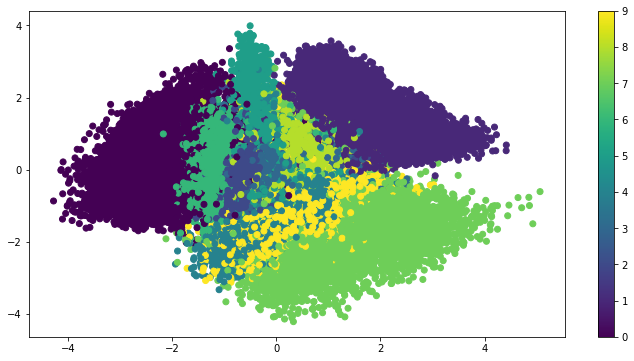

In [48]:
test_encoded = Encoder.predict(X_train, batch_size = batch_size)

plt.figure(figsize = (12, 6))
plt.scatter(test_encoded[:, 0], test_encoded[:, 1], c = y_train)
plt.colorbar()

In [52]:
examples = 10
images = X_test[:examples]

encodedImages = Encoder.predict(images)

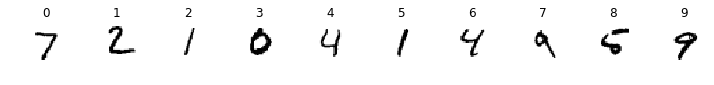

In [53]:
dim = (10, 10)
figsize = (10, 10)

plt.figure(figsize=figsize)
for i in range(examples):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(images[i].reshape((28, 28)), interpolation='nearest', cmap='gray_r')
    plt.title(i)
    plt.axis('off')
plt.tight_layout()
plt.show()

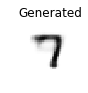

In [64]:
img_1 = encodedImages[4] 
img_2 = encodedImages[6]
img_3 = encodedImages[9]

generatedImage = Generator.predict((img_1 + img_2).reshape((1, 2)))

plt.figure(figsize=figsize)
plt.subplot(dim[0], dim[1], 1)
plt.imshow(generatedImage.reshape((28, 28)), interpolation='nearest', cmap='gray_r')
plt.title("Generated")
plt.axis('off')
plt.show()

### Generator

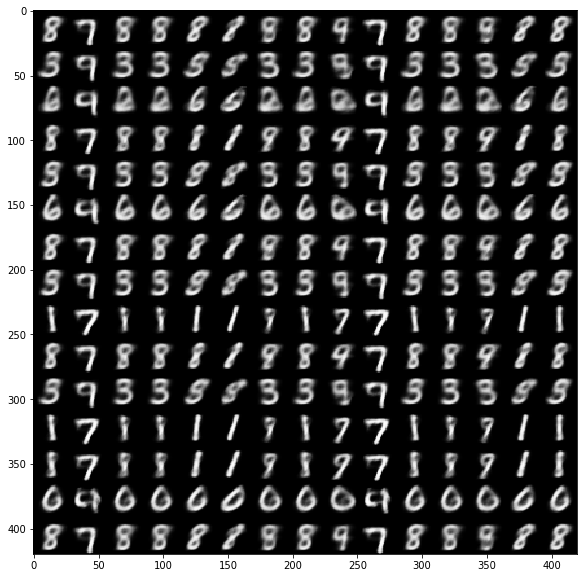

In [76]:
value_to_generate = 15

normal_x = np.random.normal(loc = 0.0, scale = 1.0, size = value_to_generate)
normal_y = np.random.normal(loc = 0.0, scale = 1.0, size = value_to_generate)

generated_images = np.zeros((28 * value_to_generate, 28 * value_to_generate))

for i, n_x in enumerate(normal_x):
    for j, n_y in enumerate(normal_y):
        z_sample = np.array([[n_x, n_y]], dtype = 'float32')
        x_decoded = Generator.predict(z_sample)
        digit = x_decoded[0].reshape((28, 28))
        
        generated_images[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit
        
plt.figure(figsize = (10, 10))
plt.imshow(generated_images, cmap = 'Greys_r')
#plt.imsave('GeneratedImages_10', generated_images, dpi = 100, format = 'png', cmap = 'Greys_r')

## END